# Task 1:

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
c:\Users\makal\anaconda3\envs\pm3env\lib\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
c:\Users\makal\anaconda3\envs\pm3env\lib\site-packages\sklearn\cluster\_kmeans.py:1962: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1024 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(
c:\Users\makal\anaconda3\envs\pm3env\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chu

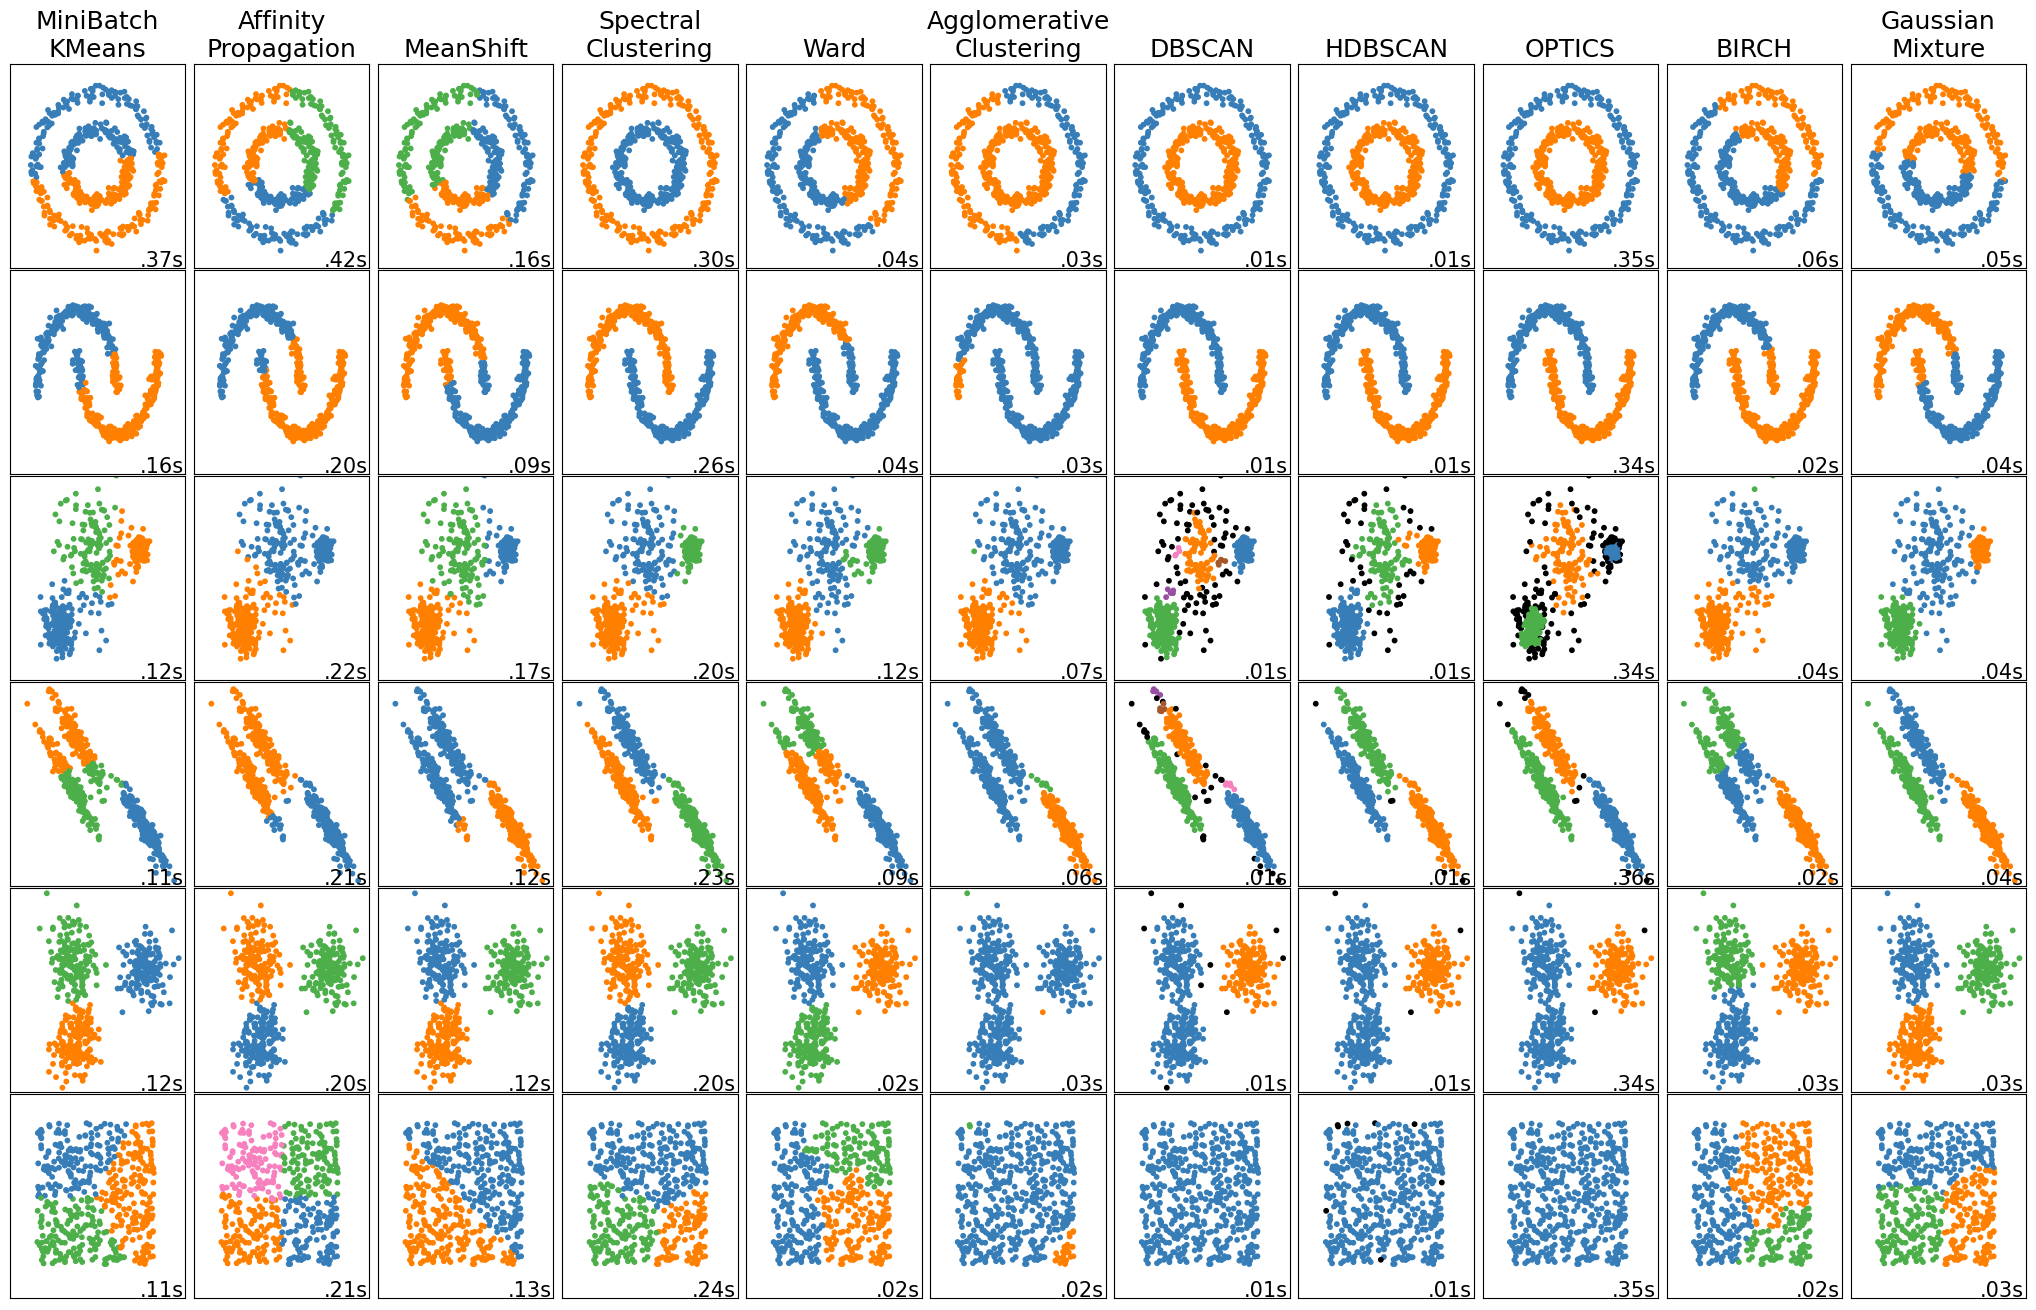

In [1]:
import time
import warnings
from itertools import cycle, islice

import matplotlib.pyplot as plt
import numpy as np

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 500
seed = 30
noisy_circles = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed
)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=seed)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=seed)

rng = np.random.RandomState(seed)
no_structure = rng.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 3,
    "n_clusters": 3,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
    "allow_single_cluster": True,
    "hdbscan_min_cluster_size": 15,
    "hdbscan_min_samples": 3,
    "random_state": 42,
}

datasets = [
    (
        noisy_circles,
        {
            "damping": 0.77,
            "preference": -240,
            "quantile": 0.2,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.08,
        },
    ),
    (
        noisy_moons,
        {
            "damping": 0.75,
            "preference": -220,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.1,
        },
    ),
    (
        varied,
        {
            "eps": 0.18,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.01,
            "min_cluster_size": 0.2,
        },
    ),
    (
        aniso,
        {
            "eps": 0.15,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.1,
            "min_cluster_size": 0.2,
        },
    ),
    (blobs, {"min_samples": 7, "xi": 0.1, "min_cluster_size": 0.2}),
    (no_structure, {}),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(
        n_clusters=params["n_clusters"],
        random_state=params["random_state"],
    )
    ward = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity
    )
    spectral = cluster.SpectralClustering(
        n_clusters=params["n_clusters"],
        eigen_solver="arpack",
        affinity="nearest_neighbors",
        random_state=params["random_state"],
    )
    dbscan = cluster.DBSCAN(eps=params["eps"])
    hdbscan = cluster.HDBSCAN(
        min_samples=params["hdbscan_min_samples"],
        min_cluster_size=params["hdbscan_min_cluster_size"],
        allow_single_cluster=params["allow_single_cluster"],
    )
    optics = cluster.OPTICS(
        min_samples=params["min_samples"],
        xi=params["xi"],
        min_cluster_size=params["min_cluster_size"],
    )
    affinity_propagation = cluster.AffinityPropagation(
        damping=params["damping"],
        preference=params["preference"],
        random_state=params["random_state"],
    )
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average",
        metric="cityblock",
        n_clusters=params["n_clusters"],
        connectivity=connectivity,
    )
    birch = cluster.Birch(n_clusters=params["n_clusters"])
    gmm = mixture.GaussianMixture(
        n_components=params["n_clusters"],
        covariance_type="full",
        random_state=params["random_state"],
    )

    clustering_algorithms = (
        ("MiniBatch\nKMeans", two_means),
        ("Affinity\nPropagation", affinity_propagation),
        ("MeanShift", ms),
        ("Spectral\nClustering", spectral),
        ("Ward", ward),
        ("Agglomerative\nClustering", average_linkage),
        ("DBSCAN", dbscan),
        ("HDBSCAN", hdbscan),
        ("OPTICS", optics),
        ("BIRCH", birch),
        ("Gaussian\nMixture", gmm),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()

c:\Users\makal\anaconda3\envs\pm3env\lib\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
c:\Users\makal\anaconda3\envs\pm3env\lib\site-packages\sklearn\cluster\_kmeans.py:1962: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1024 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(
c:\Users\makal\anaconda3\envs\pm3env\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\makal\anaconda3\envs\pm3env\lib\site-packages\sklearn\cluster\_

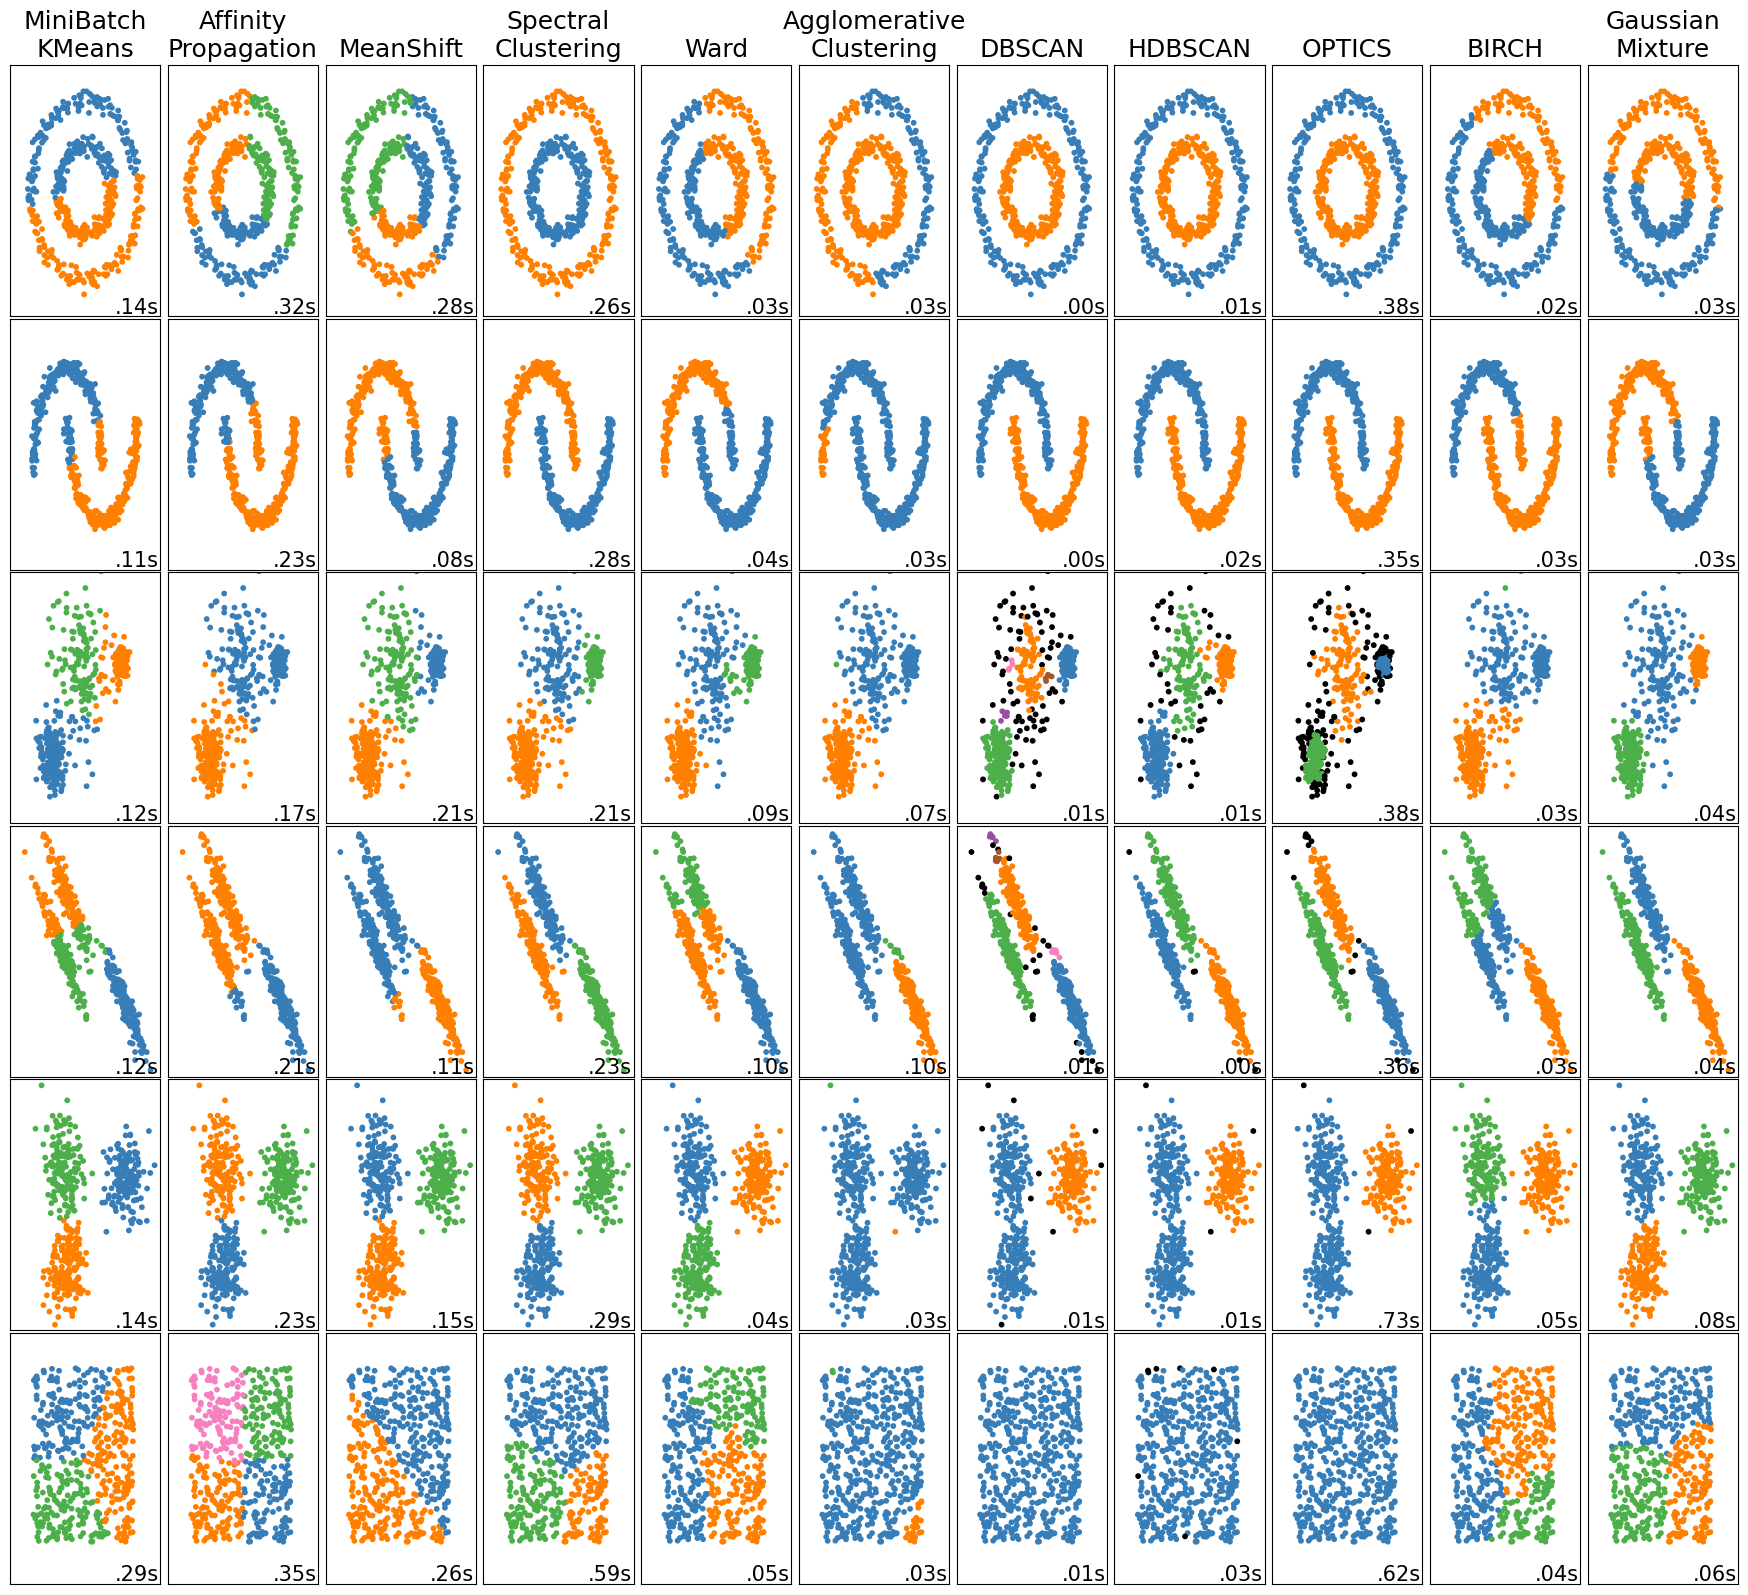

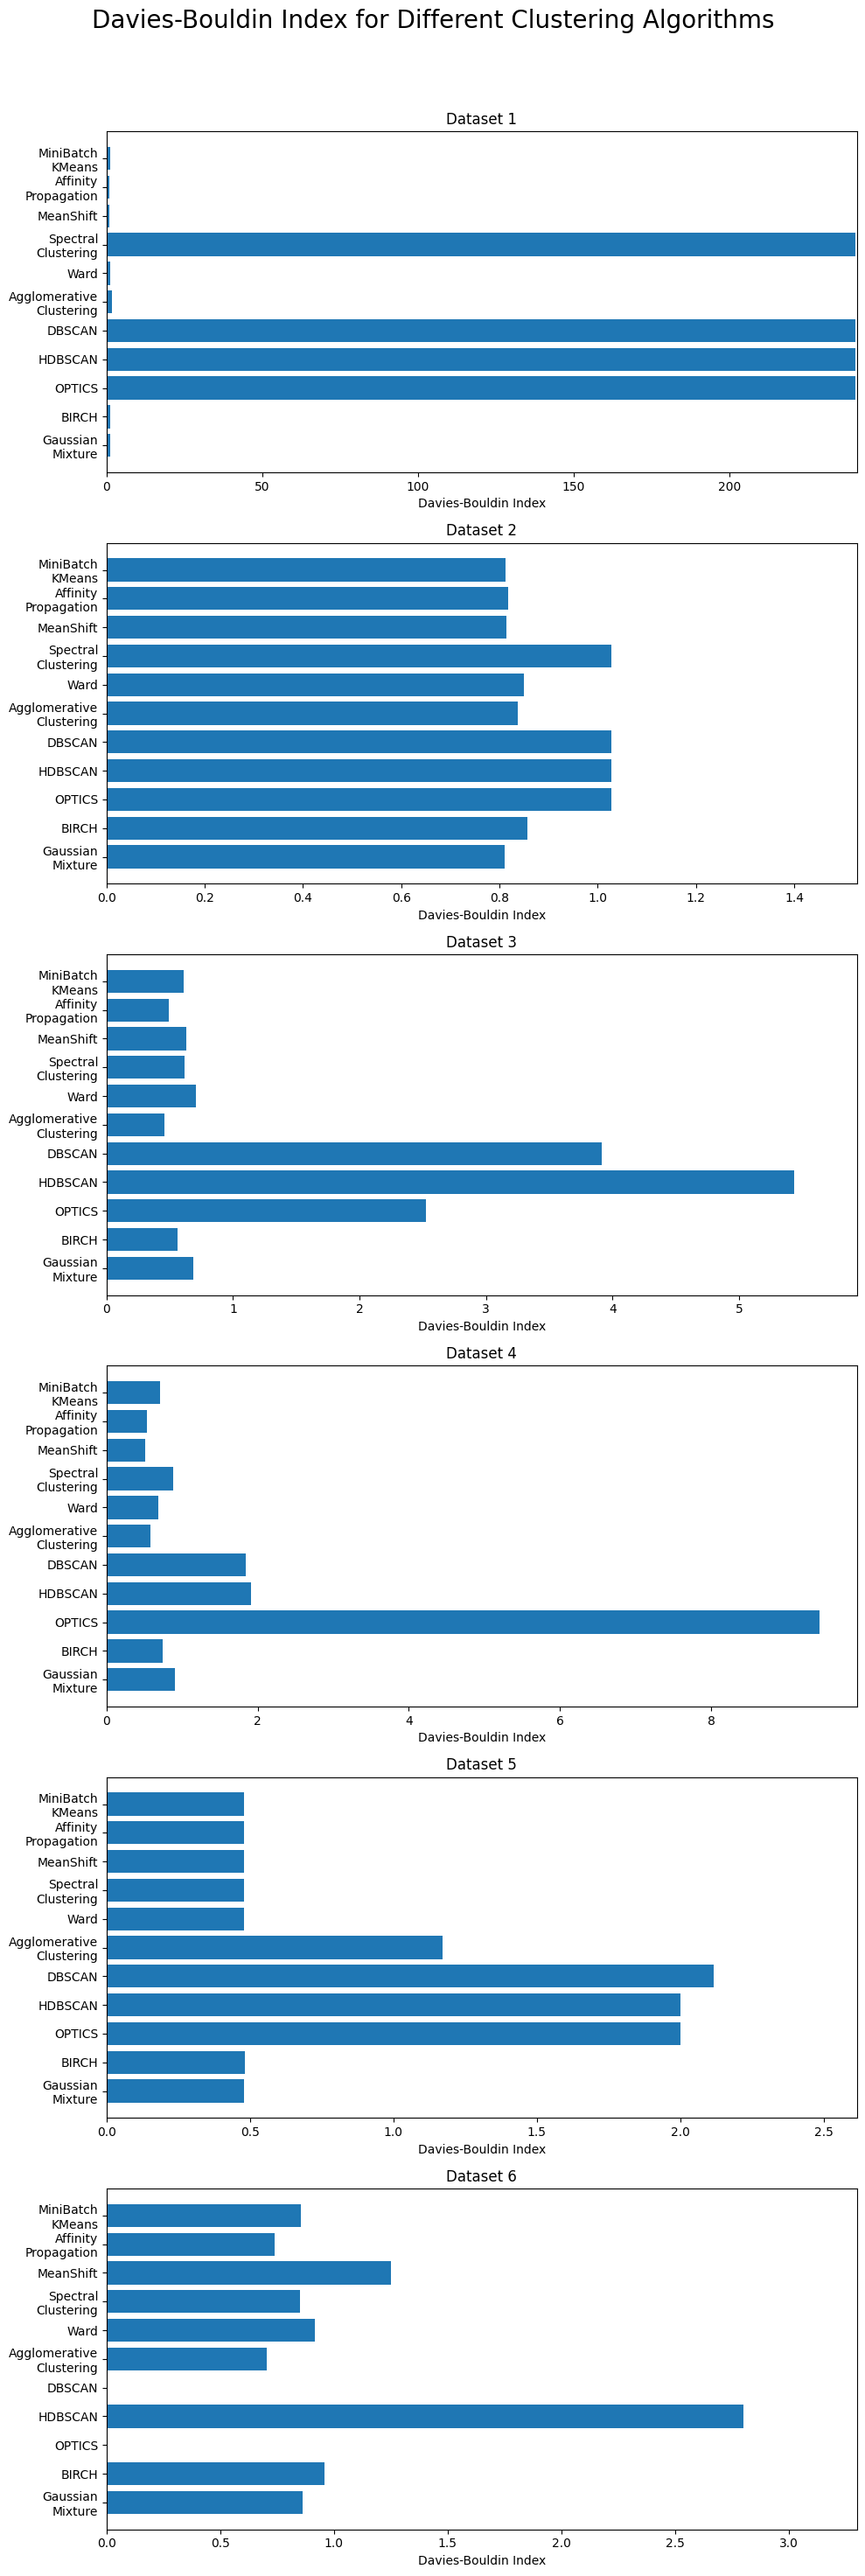

In [10]:
import time
import warnings
from itertools import cycle, islice

import matplotlib.pyplot as plt
import numpy as np

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 500
seed = 30
noisy_circles = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed
)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=seed)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=seed)

rng = np.random.RandomState(seed)
no_structure = rng.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(18, 16))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 3,
    "n_clusters": 3,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
    "allow_single_cluster": True,
    "hdbscan_min_cluster_size": 15,
    "hdbscan_min_samples": 3,
    "random_state": 42,
}

datasets = [
    (
        noisy_circles,
        {
            "damping": 0.77,
            "preference": -240,
            "quantile": 0.2,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.08,
        },
    ),
    (
        noisy_moons,
        {
            "damping": 0.75,
            "preference": -220,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.1,
        },
    ),
    (
        varied,
        {
            "eps": 0.18,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.01,
            "min_cluster_size": 0.2,
        },
    ),
    (
        aniso,
        {
            "eps": 0.15,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.1,
            "min_cluster_size": 0.2,
        },
    ),
    (blobs, {"min_samples": 7, "xi": 0.1, "min_cluster_size": 0.2}),
    (no_structure, {}),
]

# Dictionary to store Davies-Bouldin scores
db_scores = {i: [] for i in range(len(datasets))}


for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(
        n_clusters=params["n_clusters"],
        random_state=params["random_state"],
    )
    ward = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity
    )
    spectral = cluster.SpectralClustering(
        n_clusters=params["n_clusters"],
        eigen_solver="arpack",
        affinity="nearest_neighbors",
        random_state=params["random_state"],
    )
    dbscan = cluster.DBSCAN(eps=params["eps"])
    hdbscan = cluster.HDBSCAN(
        min_samples=params["hdbscan_min_samples"],
        min_cluster_size=params["hdbscan_min_cluster_size"],
        allow_single_cluster=params["allow_single_cluster"],
    )
    optics = cluster.OPTICS(
        min_samples=params["min_samples"],
        xi=params["xi"],
        min_cluster_size=params["min_cluster_size"],
    )
    affinity_propagation = cluster.AffinityPropagation(
        damping=params["damping"],
        preference=params["preference"],
        random_state=params["random_state"],
    )
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average",
        metric="cityblock",
        n_clusters=params["n_clusters"],
        connectivity=connectivity,
    )
    birch = cluster.Birch(n_clusters=params["n_clusters"])
    gmm = mixture.GaussianMixture(
        n_components=params["n_clusters"],
        covariance_type="full",
        random_state=params["random_state"],
    )

    clustering_algorithms = (
        ("MiniBatch\nKMeans", two_means),
        ("Affinity\nPropagation", affinity_propagation),
        ("MeanShift", ms),
        ("Spectral\nClustering", spectral),
        ("Ward", ward),
        ("Agglomerative\nClustering", average_linkage),
        ("DBSCAN", dbscan),
        ("HDBSCAN", hdbscan),
        ("OPTICS", optics),
        ("BIRCH", birch),
        ("Gaussian\nMixture", gmm),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )

        plot_num += 1

        # Calculate Davies-Bouldin score
        if len(np.unique(y_pred)) > 1:
            db_score = davies_bouldin_score(X, y_pred)
        else:
            db_score = np.inf
            # pass 
        db_scores[i_dataset].append(db_score)


# Plot Davies-Bouldin
fig, ax = plt.subplots(len(datasets), 1, figsize=(10, 30))
fig.suptitle('Davies-Bouldin Index for Different Clustering Algorithms', size=20)
algorithm_names = [name for name, _ in clustering_algorithms]

for i, (dataset_name, scores) in enumerate(db_scores.items()):
    ax[i].barh(algorithm_names, scores)
    filtered_scores = [score for score in scores if np.isfinite(score)]
    if filtered_scores:
        max_score = max(filtered_scores)
        ax[i].set_xlim(0, max_score + 0.5)
    else:
        ax[i].set_xlim(0, 5)  # Set a default limit if all scores are NaN or Inf

    ax[i].set_title(f'Dataset {i+1}')
    ax[i].set_xlabel('Davies-Bouldin Index')
    ax[i].invert_yaxis()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()




{0: [1.1960872633876982, 0.8423595983023663, 0.8506229298836381, 240.58612084406082, 1.1980468579832928, 1.7437008840376886, 240.58612084406082, 240.58612084406082, 240.58612084406082, 1.2387186836343513, 1.1986795664900631], 1: [0.8114498623975757, 0.8179427030957191, 0.8135545718911422, 1.0281364734204288, 0.8505542810246334, 0.8380987465834002, 1.0281364734204288, 1.0281364734204288, 1.0281364734204288, 0.8576396965319645, 0.8111591333259325], 2: [0.6103657512894457, 0.4929394090407599, 0.6333591199165257, 0.6169401338507057, 0.7043179505106556, 0.4559530233389603, 3.916854903347633, 5.433780469011317, 2.523791911975756, 0.5597325693754405, 0.6845989350749178], 3: [0.7074845218867195, 0.5355324946856769, 0.5149713525055785, 0.8834213799333742, 0.6860462855104682, 0.5854555557065163, 1.8390526081691116, 1.9077623085280502, 9.430885019869992, 0.744018790439488, 0.9085085238891172], 4: [0.4792854291388702, 0.47928542913887023, 0.47928542913887023, 0.47993379972674904, 0.479933799726749

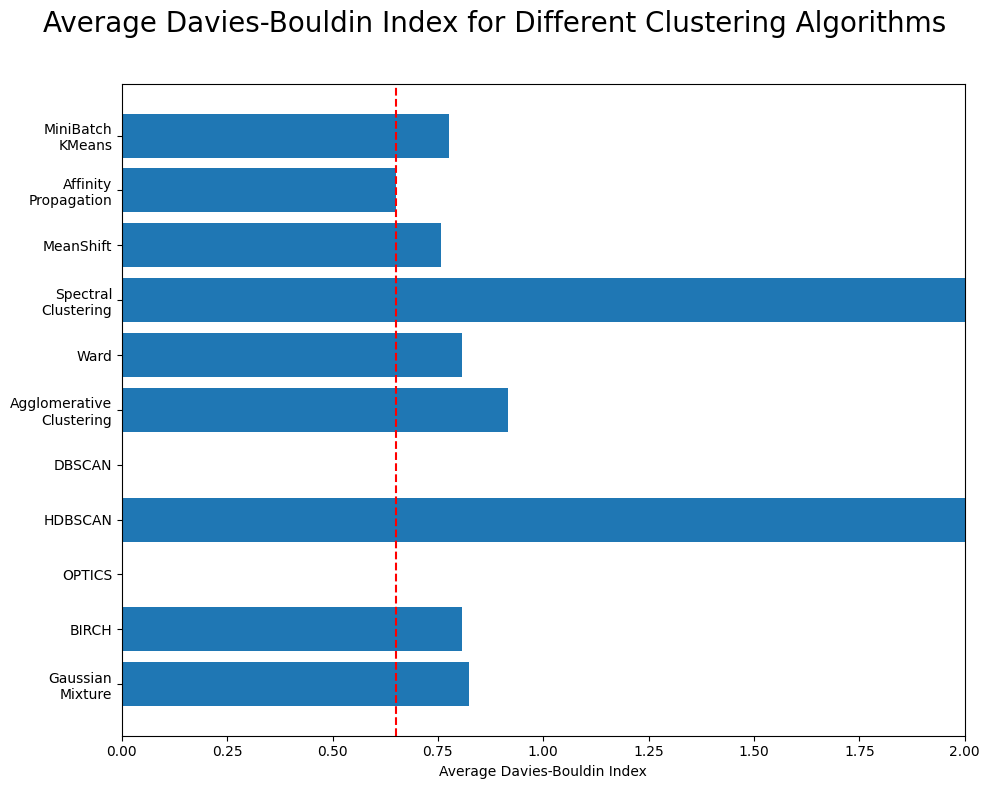

In [18]:
# Plot average Davies-Bouldin scores
print(db_scores)
average_db_scores = [np.nanmean([db_scores[i][j] for i in db_scores]) for j in range(len(algorithm_names))]

min_average_db_score = min(average_db_scores)

fig, ax = plt.subplots(figsize=(10, 8))
fig.suptitle('Average Davies-Bouldin Index for Different Clustering Algorithms', size=20)

ax.barh(algorithm_names, average_db_scores)
ax.axvline(min_average_db_score, color='red', linestyle='--', linewidth=1.5)
ax.set_xlim(0, 2)
ax.set_xlabel('Average Davies-Bouldin Index')
ax.invert_yaxis()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Taking into account the average score for different datasets, the best result was earned by Affinity Propagation.

Visual inspection of clustering correctness 
and Davies-Bouldin index don't consistent results.

For example for dataset 1 methods Spectral Clusterintg, DBSCAN, HDBSCAN, OPTICS and BIRCH gave the best results (Visual inspection) but got highest Davies-Bouldin score (the lower, the better)

Davies-Bouldin score is not good metrix for complex clusters shapes.

# Task 2:

## K-means Clustering
K-means Clustering is a popular partitioning method that divides a dataset into 
𝑘
k distinct, non-overlapping clusters based on feature similarity.

### Operation:
 - Initialization: Select k initial centroids randomly from the dataset.

 - Assignment: Assign each data point to the nearest centroid, forming k clusters.

 - Update: Recalculate the centroids as the mean of all points in each cluster.

 - Repeat: Repeat the assignment and update steps until the centroids no longer change or a maximum number of iterations is reached.

### Advantages:
 - Simple and easy to implement.

 - Efficient for large datasets.

 - Works well for spherical clusters.

### Disadvantages:

 - Requires specifying the number of clusters k in advance.

 - Sensitive to the initial placement of centroids.

 - Assumes clusters are of similar size and shape.

## DBSCAN (Density-Based Spatial Clustering of Applications with Noise)
DBSCAN is a density-based clustering algorithm that can identify clusters of arbitrary shape and can handle noise (outliers).

### Operation:
- Parameters: Define two parameters: ϵ (epsilon) – the radius for neighborhood search, and 
minPts – the minimum number of points required to form a dense region (core point).
- Core Points: Identify core points, which have at least minPts neighbors within a distance of ϵ.
- Cluster Formation: Connect core points and their neighbors to form clusters. Points reachable from core points form the cluster.
- Noise Identification: Points that are not reachable from any core point are classified as noise.
### Advantages:
- Does not require specifying the number of clusters in advance.
- Can find arbitrarily shaped clusters.
- Robust to noise and outliers.
### Disadvantages:
- Choosing the appropriate ϵ and minPts values can be challenging.
- Performance can degrade with high-dimensional data.

## Gaussian Mixture Models (GMM)
Gaussian Mixture Models use a mixture of several Gaussian distributions to model data. Each Gaussian component represents a cluster, and data points are assumed to be generated from these distributions.

### Operation:
1. Initialization: Initialize parameters (means, variances, and mixing coefficients) of the Gaussian distributions. This can be done using methods like K-means.
2. Expectation-Maximization (EM) Algorithm:
- Expectation (E-step): Calculate the probability (responsibility) that each data point belongs to each Gaussian component using the current parameters.
- Maximization (M-step): Update the parameters (means, variances, and mixing coefficients) to maximize the likelihood of the data given these responsibilities.
3.  Iteration: Repeat the E-step and M-step until convergence (when parameters change very little between iterations).
### Advantages:
- Flexibility: Can model clusters of different shapes and sizes due to the probabilistic nature of Gaussian distributions.
- Soft Clustering: Provides probabilities for each point belonging to each cluster, allowing for soft clustering where points can belong to multiple clusters with different probabilities.
- Expectation-Maximization: The EM algorithm efficiently finds the maximum likelihood estimates for the parameters.
### Disadvantages:
- Computational Complexity: Can be computationally intensive, especially with a large number of dimensions or data points.
- Number of Components: Requires specifying the number of Gaussian components (clusters) in advance.
- Local Optima: Like K-means, GMM can get stuck in local optima, so results may depend on initial parameter settings.

# Task 3:

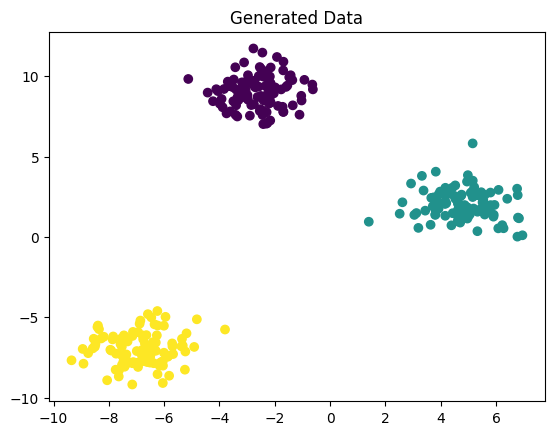

Final centroids:
 [[-6.88387179 -6.98398415]
 [-2.63323268  9.04356978]
 [ 4.74710337  2.01059427]]


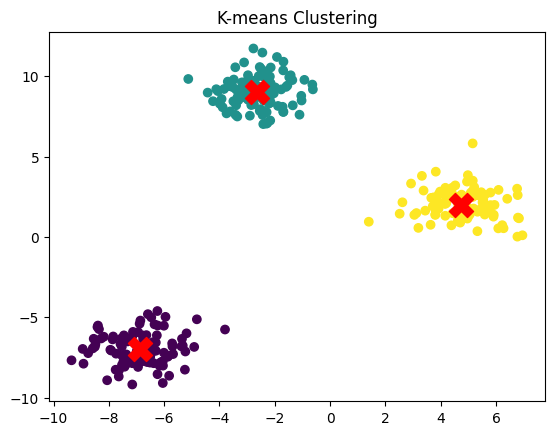

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# Generate sample data
n_samples = 300
n_features = 2
n_clusters = 3
X, y = make_blobs(n_samples=n_samples, centers=n_clusters, n_features=n_features, random_state=42)

# Visualize the generated data
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
plt.title('Generated Data')
plt.show()

def initialize_centroids(X, k):
    n_samples, n_features = X.shape
    centroids = np.zeros((k, n_features))
    for i in range(n_features):
        min_val = np.min(X[:, i])
        max_val = np.max(X[:, i])
        centroids[:, i] = np.random.uniform(min_val, max_val, size=k)
    return centroids

def compute_distances(X, centroids):
    distances = np.zeros((X.shape[0], centroids.shape[0]))
    for i in range(centroids.shape[0]):
        distances[:, i] = np.linalg.norm(X - centroids[i], axis=1)
    return distances

def k_means(X, k, max_iters=100, tol=1e-4):
    centroids = initialize_centroids(X, k)
    for _ in range(max_iters):
        old_centroids = centroids.copy()
        
        # Step 1: Assign points to the nearest centroid
        distances = compute_distances(X, centroids)
        labels = np.argmin(distances, axis=1)
        
        # Step 2: Recalculate centroids
        for i in range(k):
            if np.any(labels == i):
                centroids[i] = X[labels == i].mean(axis=0)
        
        # Check for convergence
        if np.linalg.norm(centroids - old_centroids) < tol:
            break
            
    return centroids, labels

# Run K-means
final_centroids, labels = k_means(X, n_clusters)
print("Final centroids:\n", final_centroids)

# Visualize the final clusters
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
plt.scatter(final_centroids[:, 0], final_centroids[:, 1], s=300, c='red', marker='X')
plt.title('K-means Clustering')
plt.show()
